<a href="https://colab.research.google.com/github/richardOlson/nfl_2019_play_by_play/blob/master/nfl_plays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install pandas-profiling==2.*
# I saved the pandas profile on the local computure and then I 
# removed the code for creating the pandas profiling so that it wouldn't 
# have to take time running this again.

In [0]:
%%capture
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost
import pickle
import sklearn


In [0]:
# Getting the versions for the xgbost and pickle
print(f"xgboost version is:{xgboost.__version__}")
print(f"pickle version is: {pickle.format_version}")
print(f"sklearn version is: {sklearn.__version__}")

xgboost version is:0.90
pickle version is: 4.0
sklearn version is: 0.22.1


In [0]:
df19 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play2019.csv')

In [0]:
df17 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play_2017.csv')

In [0]:
df18 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play_2018.csv')

In [0]:
df16 = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/play_by_play_2016.csv')

In [0]:
df16.shape , df17.shape, df18.shape, df19.shape

((45951, 45), (45293, 45), (45016, 45), (42186, 45))

In [0]:
d18 = df18.copy()
d19 = df19.copy()
d17 = df17.copy()
d16 = df16.copy()

In [0]:
# Seeing what the values for the playTypes are
df18['PlayType'].value_counts(dropna=False)

PASS                    18492
RUSH                    12173
KICK OFF                 2645
PUNT                     2295
TIMEOUT                  1866
NaN                      1560
SACK                     1370
EXTRA POINT              1229
FIELD GOAL                948
NO PLAY                   829
SCRAMBLE                  826
QB KNEEL                  393
TWO-POINT CONVERSION      134
EXCEPTION                  91
FUMBLES                    85
CLOCK STOP                 78
PENALTY                     2
Name: PlayType, dtype: int64

In [0]:


# make minute second into one column as a float
# Steps separte into games
# order into quarters in each game
# order each quarter descending in time
# need to remove rows where time == 0.00

In [0]:
# All the functions in this code cell are involved in the wrangling of the data.
# The separate functions will all be called in the wrangle2 function.
# I called it 'wrangle2' becuase there was a previous wrangle function.


# Separating the plays by game id.
# making the function that will separte the dataFrame by games
# A  list is returned that has the dataframe divided up by game
def separateToGameId(dataFrame):
# first getting the unique values for game id
# Unique will return an numpy array
  unique_games = dataFrame['GameId'].unique()
# Building a list of dataFrame of unique games
  games = [dataFrame[dataFrame['GameId'] == x] for x in unique_games]
  
  return  games







#------------------------------------------------------------------------
            # Score making functions

# making the score

# Function for checking if there is a touchDown
# It will return a number if there really was no touchdown
# If there is a touchdown then it will return the team who scored the touchdown

def whoScored(df, i, row_description):
  theCounter = i+1
  numberOfSearches = 1
  secondaryCount = i +1
  playReversed = row_description.rfind("PLAY WAS REVERSED")
  touchDown = row_description.rfind('TOUCHDOWN')
  time_touchdown_occured = df.iloc[i]['SecondsLeftInGame']
  extraPointTime = 0
  # Looking at the end of the game or the the end of the half
  endHalf = time_touchdown_occured < 1800 and time_touchdown_occured > 179
  if i >= len(df) -3:
    for j in range(i, len(df)):
      if (df.iloc[j]['PlayType'] == 'KICK OFF' or df.iloc[j]['IsTwoPointConversion'] == 1 
          or df.iloc[j]["PlayType"] == 'EXTRA POINT'):
        
        return df.iloc[j]['OffenseTeam']
    # if the following if statement is false that means that there was no 
    # touchdown. Some penalty caused it to be called back.
    if touchDown > playReversed:
      return df.iloc[i]['OffenseTeam']
    else:
      return theCounter
  # This means that the play was reversed
  if touchDown > playReversed:
    # If in here will be looking to see what team it is that has scored
    for num in range(i+1,i+4,1):
      # Adding this to stop from going out of the index
      if i == len(df)-4:
        num -=1
      #if numberOfSearches <= 3:
      if (df.iloc[num]['PlayType'] == 'EXTRA POINT' or df.iloc[num]['IsTwoPointConversion'] == 1): 
        # Setting the time that the extra point or two point conversion happened
        extraPointTime = df.iloc[num]['SecondsLeftInGame']
         # Choosing the stop point for the loop in searching for the
        # kickoff.  Making sure index isn't out of bounds
        stopPoint = i+10 if 10 < (len(df) - i) else len(df)
        for j in range(i+1, stopPoint, 1):
          #Now searching for a kickoff to see if they will match to
          #the Extra Point or two Point conversion 
          #Find the team that scored
          if df.iloc[j]['PlayType']  == "KICK OFF" and df.iloc[j]['SecondsLeftInGame'] == extraPointTime:
            return df.iloc[j]['OffenseTeam']
      # incrementing the counter
      theCounter +=1
      numberOfSearches +=1

  # Will check to see if the extra point and the kick off happened same time 
  # The time ordering can put it in front of the touchdown
  
    for j in range(i-1, i-3, -1):
      # This is a boolean to see if they occured the same time
      kick_or_two_point_time = time_touchdown_occured == df.iloc[j]['SecondsLeftInGame']
      if kick_or_two_point_time == True and df.iloc[j]['PlayType'] == "KICK OFF":
        return df.iloc[j]['OffenseTeam']
      elif kick_or_two_point_time == True and df.iloc[j]['PlayType'] == "EXTRA POINT":
        return df.iloc[j]['OffenseTeam']
      elif kick_or_two_point_time == True and df.iloc[j]['IsTwoPointConversion'] == 1:
        return df.iloc[j]['OffenseTeam']

      #df.iloc[secondaryCount]['PlayType'] == 'EXTRA POINT':
      #  secondaryCount +=1
      #  return df.iloc[i+1]["OffenseTeam"]
    
      
      # will return the counter if there was a penalty
  return theCounter
    


# This method will return a list that contains the scores
# in the football game but as one integer.
#  The number is representative of the offenseTeam.  0 means tie.
# 7 means the offense team is 7 points ahead.  -7 means the offense team is 
# 7 points behind.
def createScore(df):
  # This is the list that will keep the score 
  score = [0]
  # This the the first team
  trow = df.iloc[0]
  team = ''
  teamScored = ''
  newScore = 0

  for i in range(len(df)):
    # get the current team
    team = df.iloc[i]['OffenseTeam']

    if i == (len(df) -1):
      # Don't want to do anything to the score if it is the
      # last play of the game.
      #newScore = score[i]
      return score

    row = df.iloc[i]
    row_description = row['Description']
    nextPlay = df.iloc[i + 1]

    # TouchDown
    if row['IsTouchdown'] == 1:

      scoringTeam = whoScored(df, i, row_description)
      # This would mean that no one scored
      if isinstance(scoringTeam, int):
        if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
        else:
          newScore = score[i] + 0
      # Checking to see who scored the touchDown
      # making the score a negative
      elif team !=  nextPlay['OffenseTeam'] :
        if scoringTeam != team:
          newScore  = (score[i] - 6) * -1 
        else:
          newScore = ((score[i] + 6) *-1)
        
                   
      else:
    
        if scoringTeam != team:
          newScore = score[i] -6  
        else:       
          newScore = (score[i] + 6)
        
        
        # adding the new score to the list
      score.append(newScore)
       # Checking for an extra point  
        
    elif row['PlayType'] == "EXTRA POINT" :
      
      if row_description.find('IS GOOD') != -1:
        if nextPlay['OffenseTeam'] != team:
          newScore = ((score[i] + 1) * - 1)
        else:
          newScore = score[i] + 1
          # if it was missed
      elif nextPlay['OffenseTeam'] != team:
        newScore = (score[i] * -1)
      else:
        newScore = score[i] + 0
      score.append(newScore)

    # Field Goals    
    elif  row['PlayType'] == 'FIELD GOAL':
      # This is the team that has kicked the field goal
      
      if row_description.find('IS GOOD') != -1:
        
        if nextPlay['OffenseTeam'] == team:
          newScore = score[i] + 3
        else:
          newScore = ((score[i] + 3) * -1)
      # if the field goal was missed and no TouchDown
      else:
        if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
        else:
          newScore = score[i] + 0
      score.append(newScore)
    # Doing two point conversions
    elif row['IsTwoPointConversion'] == 1:
      if row['IsTwoPointConversionSuccessful'] == 1:
        
        if nextPlay['OffenseTeam'] == team:
          newScore = (score[i] + 2)
        else:
          newScore = ((score[i] + 2) * -1)
          
      else:  # Tried the two Point conversion, not succesfull
        # will check to see if there was a defensive two point 
        # conversion
        two =  row_description.find('DEFENSIVE TWO-POINT ATTEMPT') 
        if two != -1 and two > row_description.find('ATTEMPT FAILS'):
          # defense scored
          if nextPlay['OffenseTeam'] == team:
            newScore = score[i] -2
          else:
            newScore = (score[i] -2) * -1
        elif nextPlay['OffenseTeam'] == team:
          newScore = score[i]
        else:
          newScore = (score[i] * -1)
      
       # Putting the newscore in the list 
      score.append(newScore)

    # Doing safties
    
    elif row_description.find('SAFETY') != -1:
      # Checking if the next play is a kickoff by same
      
      if nextPlay['OffenseTeam'] == team:
        # Using i - 2 because the team who is the offense has
        # not changed yet because they now have to kick the ball and are considered
        # offense still but the defense scored so it is negative
        newScore = score[i] - 2
      else:
        newScore = ((score[i] - 2) * -1)
      score.append(newScore)
    
    # Deciding what to do on all other plays
    else:
         
        # Other Team has the ball
      if nextPlay['OffenseTeam'] != team:
          newScore = (score[i] * -1)
      else:
        newScore = score[i]
      # appending the newScore
      score.append(newScore)

        
        


              # End of Score making functions
#---------------------------------------------------------------------------------



        


# Separating the each game by the teams when on offense and then reordering
# with the secondsTillgame column.
# This method will return a list that has 
# the games divided by each team
def separateByTeam(games):
  firstTeam = ''
  secondTeam = ''
  newGamesList = []
  for game in games:
    firstTeam = game.iloc[0]['OffenseTeam']
    for i in range(len(game)):
      if game.iloc[i]["OffenseTeam"] != firstTeam:
        secondTeam = game.iloc[i]["OffenseTeam"]
        break
    # Separating each game by each team when they are
    # on offense
    first = game[game['OffenseTeam'] == firstTeam]
    second = game[game['OffenseTeam'] == secondTeam]
    newGamesList.append(first)
    newGamesList.append(second) 
  # returning the list that contains the games broken down by team 
  # when they are on offense
  return newGamesList  





# Creating a method to make the seconds till end of game
def makeSecondsTillEnd(df):
  # make a list
  secondsList = []

  for i in range(len(df.index)):
    
    row = df.iloc[i]
    if row['Quarter'] == 5:
      ans = (row['Minute'] * 60) + row['Second']
      # Overtime is for only 10 minutes
      ans = ((600 - ans) * -1)
      secondsList.append(ans)
    else:
      ans = ((4 - row['Quarter'] )* 900) + (row['Minute'] * 60) + row['Second']
      secondsList.append(ans)
  return secondsList
  



# We will now make the target feature
# I want a name and not one or zero or True or False
def makeTarget(df):
  #df = df.copy()
  mask = (df['IsRush'] == 1)
  theList = []
  for i in range(len(df)):
    if mask.iloc[i] == 1:
      theList.append('Rush')
    else:
      theList.append('Pass')
      
  df['Play'] = theList
  
   
  return df




# making columns for each down
# Trying to see if this will make model see the importance of the down that it is on
# This method will drop the toGo and the down features
def makeDownCols(df):
  first = []
  second = []
  third = []
  fourth = []
  twoPoint = []
  for i in range(len(df)):
    if df.iloc[i]['Down'] == 1:
      first.append(df.iloc[i]['ToGo'])
      second.append(0)
      third.append(0)
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 2:
      first.append(0)
      second.append(df.iloc[i]['ToGo'])
      third.append(0)
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 3:
      first.append(0)
      second.append(0)
      third.append(df.iloc[i]['ToGo'])
      fourth.append(0)
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 4:
      first.append(0)
      second.append(0)
      third.append(0)
      fourth.append(df.iloc[i]['ToGo'])
      twoPoint.append(0)
    elif df.iloc[i]['Down'] == 0:
      first.append(0)
      second.append(0)
      third.append(0)
      fourth.append(0)
      twoPoint.append(df.iloc[i]['ToGo'])
      
  

  df['first_to_go'] = first
  df['second_to_go'] = second
  df['third_to_go'] = third
  df['fourth_to_go'] = fourth
  df['two_point_to_go'] = twoPoint
    
  return df



#----------------------------------------------------------------
       # Functions for making the prev play categories
# creating the function that will categorize
# how succesfull a play is.
# Folowing what was determined by 
# Bob Carroll and Pete Palmer and John Thorn, in their
# book called "The Hidden Game of Football".
# Also using a method similar to those on Footballoutsiders.com

# First Down play need --- 45% of required yards (yards for first down)to get a point
# Second Down play needs-- 60% of required yards (yards for first down)
# Third and Forth need 100 % of required yards to first down to be succes

def getPercentage(down, distance):
  
  if down == 4 or down == 3:
    return distance
  if down == 2:
    return distance * .6
  if down == 1:
    return distance * .45 
    # returning this if for some reason a down is 0
  if down == 0:
    return 1

# This is an inner method that will load the 
# categories with the score
# I am using this method instead of a pandas cut 
# because I already am looping through
# the dataframe to get the score so at the
# same time will make the categories
def fillOtherCat(numberToSkip, catList):
  for i in range(len(catList)):
    if numberToSkip != i:
      catList[i].append(0)
  return catList

# This is the method that will load the categories with the correct value
def loadBothCategories(catListRun_, catListPass_,  score, thePlayType, theBins):
  fillAll = 100
  if thePlayType == 'Rush':
    # We will do the binning of the score in the categories
    # for a Run play # will only loop to be able to put in each category
    for i in range(len(theBins)):
      # if the score is greater than upper bin
      # the the score must be placed in a lower bin
      if score < theBins[i]:
        catListRun_[i].append(score)
        catListRun_ = fillOtherCat(i, catListRun_)
        # Filling in all the Pass categories with a zero
        catListPass_ = fillOtherCat(fillAll, catListPass_)
        return catListPass_ , catListRun_
  else:
    for i in range(len(theBins)):
      # if the score is greater than upper bin
      # the the score must be placed in a lower bin
      if score < theBins[i]:
        catListPass_[i].append(score)
        catListPass_ = fillOtherCat(i, catListPass_)
        # Filling in all the categories for run as zero
        catListRun_ = fillOtherCat(fillAll, catListRun_)
        return catListPass_ , catListRun_

# Succesfull play == 1 point 
# Unsuccesfull play = 0 points
# Fractional points for can by if yards are gained but not the complete
# required for the down
# First Fractional (yardsGained/YardsNeededFor45%ToFirstDown - ( .1)
# Second Fraction  (yardsGained/YardsNededFor60%ToFirstDown) -(.2)
# Third Fraction (yardsGained/YardsNeededToFirstDown) - .3
# Fourth Fraction --No Fraction if not succesfull

# Fumble == minus 2
# Interception == minus 4
# loss of 3 yards or more minus 1 point

# Got a TouchDown plus  1 point 
# Gained 15 yards 1 point
# If got a first down on a fourth down get an extra point

# Categories:
# High Success = 2 points
# Sucessfull = 1 points up to 2
# SomeWhatSucessfull =  .5 to.99
# MildlySuccesfull = greater than .25 to less than .50
# VeryLittleSucess = greater then .20 to .25
# Unsuccesfull = 0 points to .19
# BadPlay = less than 0



def createSuccesCategories(df,  asScore=False , addCatAsColumns=True):
  ''' Method to make the categories for the type of previous play

      df: The dataframe that to be worked on.

      asScore:  Default is False.  When true will cause the scores used to 
                bin the previous plays to be returned as a list.

      addCatAsColumns:  Default is True. When True it will cause the categories
                        to be added to the dataFrame and then the whole dataFrame is 
                        returned. When false will return a list that contains the categories
                        The first category is the worst and progressively getting better
                        and better to the end of the category list.
      
      Returns:    Will return list of Scores is asScore is True.  Will return list of 
                  categorieys if addCatAsColumns is False.  Otherwise will return the new
                  dataframe with the categories added to it.
                  '''
                 
  
  # This is the default score for the first play
  defaultScore = .65
  playQuality = [defaultScore] # This is appended because we are looking at
                      # the previous play.  The first play recieves this
                      # score for a pretend previou play neither success nor
                      # to much success.  
  score = 0
  theScore = 0
  bins = [0, .20, .26, .51, 1.0, 2, 99]


  # This is the list that will contain the prev_plays_quality 
  prev_play_quality = []

  catNamesRun =   [ 'prev_ply_bad_run','prev_ply_no_succ_run', 'prev_ply_little_succ_run',
              'prev_ply_mild_succ_run', 'prev_ply_somewhat_succ_run', 'prev_ply_succ_run',
              'prev_ply_high_succ_run'
              ]

  catNamesPass =   [ 'prev_ply_bad_pass','prev_ply_no_succ_pass', 'prev_ply_little_succ_pass',
              'prev_ply_mild_succ_pass', 'prev_ply_somewhat_succ_pass', 'prev_ply_succ_pass',
              'prev_ply_high_succ_pass'
              ]

  

  catListPass = [[] for i in range(len(catNamesPass))]
  catListRun = [[] for i in range(len(catNamesRun))]
  
    # except for the last play becuase this has
    # no play after it.

    # Loading the default score
  # making the first row have all zeros in all the 
  # categories becuase there was no prev play
  catListRun = fillOtherCat(199, catListRun)
  catListPass = fillOtherCat(199, catListPass)
  # Not running through the last play on the list
  # becuase there is no previous play for it.
  for i in range(len(df)-1):
    score = 0
    row = df.iloc[i]
    down = row['Down']
    
    if row['IsTwoPointConversion'] == 1:
      down = 4

    percentage = getPercentage(down, row['ToGo'])

    theScore = (row['Yards']/ percentage)
    if theScore >= 1:
      score = 1
      if down == 4:
        score += 1
    else:
      score = theScore - (down/10)
    
    if df.iloc[i]['IsInterception'] == 1:
      score = score - 4
    if df.iloc[i]['IsFumble'] == 1:
      score = score -2
    if df.iloc[i]['Yards'] >= 15:
      score = score + 1
    if df.iloc[i]['IsTouchdown'] == 1:
      score = score + 1
  # Getting the type of play that was done 
    thePlayType = row['Play']

    # making the score a float of 2 digits

    score = round(float(score), 3)
  

    playQuality.append(score)
    #catList, theScore, theBins
    catListPass, catListRun = loadBothCategories(catListRun, catListPass,
                       score, thePlayType, bins )
  if  asScore== True:
    
    # This will not have the last score in it
    return playQuality
  else:
    # Returning the list of each category
    if addCatAsColumns:
      # Returning whole dataFrame with categories added
      for i in range(len(catNamesRun)):
        df[catNamesRun[i]] = catListRun[i]
        df[catNamesPass[i]] = catListPass[i]
      return df
  theCats = [catListPass, catListRun]
  return theCats

  # End of the functions that are used to make the success categories
#----------------------------------------------------------




# My wrangle function
def wrangle2(df):
  df = df.copy()

  # Dropping some columns before doing other wrangling
  cols_to_drop_before_wrangling = [
                                 'NextScore', 'Unnamed: 10',
                                 'Unnamed: 12', 'TeamWin',
                                 'Unnamed: 16', 'Unnamed: 17',
                                 'SeasonYear', 'Challenger',
                                 'IsMeasurement', 'YardLineFixed',
                                 'YardLineDirection'                         

  ]

  cols_to_drop_after_wrangling = ['Description', 'Yards', 'Down', 'ToGo',
                                  'PlayType', 'IsIncomplete', 'IsTouchdown', 
                                  'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed',
                                  'IsInterception', 'IsFumble', 'IsPenalty',
                                  'IsTwoPointConversionSuccessful', 'RushDirection',
                                  'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay',
                                  'PenaltyType',  'PenaltyYards'

  
  ]

  df = df.drop(cols_to_drop_before_wrangling, axis=1)

  # Filling the description in the dataframe that are null with "NONE'
  df['Description'] = df['Description'].fillna(value='N', inplace=False)

  # Making so that the penalty type will say NONE instead of NAN
  df['PenaltyType'] = df['PenaltyType'].fillna( value='NONE',inplace=False)

  # Dropping the rows that have PlayType == No Play
  df = df.drop(df[(df['PlayType'] == 'NO PLAY')].index, axis=0)
  # Droppin the rows that have 'IsNoPlay == 1
  df = df.drop(df[df['IsNoPlay']== 1].index, axis=0 )

  # Removing the rows where the offense team is null
  # Getting a mask of all the values where the offense is null
  mask = (df['OffenseTeam'].isnull())
  df = df.drop(df[mask].index, axis=0)

  # Method for making the game date into dateTime
  df['GameDate'] = pd.to_datetime(df['GameDate'], infer_datetime_format=True)



  # Fixing if there was an extra point and it didn't have it marked
  mask = df['Description'].str.contains('EXTRA POINT')
  df.loc[mask, 'PlayType'] = 'EXTRA POINT'
  # Fixing if there was a Kick Off and the play type doesn't say
  mask = ((df['Description'].str.contains("KICKS")) & 
          (~df['Description'].str.contains('EXTRA POINT')) &
          (~df['Description'].str.contains('FIELD GOAL')))
  df.loc[mask, 'PlayType'] = "KICK OFF"
  # Fixing if there are any Field Goals not listed as a field goal in
  # the playtype
  mask = df['Description'].str.contains("FIELD GOAL")
  df.loc[mask, 'PlayType'] = "FIELD GOAL"



# --------------------------------------------------------------------------- #
  # Trying out the combine minSec function -- Will leave this out
  #df['Time'] = df.apply(combineMinSec, axis=1)
# ----------------------------------------------------------------------------#



  # Creating a feature of time left in game will be time left in seconds
  theSecondsList = makeSecondsTillEnd(df)

  df['SecondsLeftInGame'] =  theSecondsList

  # Will now drop the column Minute and second here so that they won't consume
  # as much memory
  df = df.drop(labels=['Minute', 'Second',], axis=1)

  # Makes the data separated into the games
  games = separateToGameId(df)

  # Trying to sort through the games with the value 'SecondsLeftInGame'
  df = df.copy()
  for game in games:
    game.reset_index(drop=True)
    game.sort_values(by='SecondsLeftInGame', ascending=False, inplace=True)
    game.reset_index(drop=True)


  # Getting the list of scores for each game
  # Will put them into a list and then add them to their respective game
  # as df['Score']
  theScores = []
  for game in games:
    theScore = createScore(game)
    theScores.append(theScore)
  # Now adding them to the games
  for i in range(len(games)):
    games[i]['Score'] = theScores[i]
    # Will also drop the gameid here
    games[i].drop(labels=['GameId'], axis=1, inplace=True)



 #------------------------------------------------------------------------------   
  # Not using this anymore
  # Sorting each game by the quarter
  # so that then we can sort it by time in each quarter
  #for i in range(len(games)):
  #  games[i] = games[i].sort_values(['Quarter'], ascending=True)

  # Sorting the games by time -- keeping it sorted by quarter also
  #listOfGames = sortByTime(games)
#--------------------------------------------------------------------


  # Will remove the rows that have the "QB KNEEL", 'EXTRA POINT' , "CLOCK STOP", 
  #'KICK OFF',  'FIELD GOAL', "PUNT", 'FUMBLES', in the PlayType column
  # This is to make it so that we are really looking at plays that are pass and run plays
  # Removing these from each of the games so that we can look at the run or pass
  for i in range(len(games)):
    # getting the mask
    m = ((games[i]['PlayType'] == 'KICK OFF') | (games[i]['PlayType'] == 'FIELD GOAL') |
        (games[i]["PlayType"] == "PUNT") |  (games[i]["PlayType"] == "FUMBLES") |
        (games[i]["PlayType"] == "QB KNEEL") | (games[i]["PlayType"] == "EXTRA POINT")  |
        (games[i]["PlayType"] == "CLOCK STOP") | (games[i]['PlayType'] == 'PENALTY' ))
    theIndex = games[i][m].index.to_list()
    games[i] = games[i].drop(theIndex , axis=0)

  games = separateByTeam(games)



  # When the PlayType is a sack or a scramble, I 
  # will make the column that says Pass to be 1.
  # This is because the great majority of sacks and scrambles occur
  # on pass plays where the quarterback can't find anyone open.
  for game in games:
    mask = (game['PlayType'] == 'SACK') | (game['PlayType'] == 'SCRAMBLE')
    
    game.loc[mask, 'IsPass'] = 1
    game.loc[mask, 'IsRush'] = 0
    # Need to fix Two Point conversions--The don't say if the 
    # Play was a pass or a rush attempt
    mask = (game['IsTwoPointConversion'] == 1) & (game['Description'].str.contains('PASS'))
    game.loc[mask, 'IsPass'] = 1
    game.loc[mask, 'IsRush'] = 0
    
    mask = (game['IsTwoPointConversion'] == 1) & (game['Description'].str.contains('RUSH'))
    game.loc[mask, "IsRush"] = 1
    game.loc[mask, "IsPass"] = 0

    # Fixing the yards 'ToGo' for two point conversions
    mask = (game['IsTwoPointConversion'] == 1)
    game.loc[mask, 'ToGo'] = 100 - game['YardLine']
    

    # adding the target to each game
    game = makeTarget(game)
    # dropping the two columns "IsPass" and 'IsRush"
    game.drop(labels=['IsPass', 'IsRush'], axis=1, inplace=True)

    #Creating a column called "yards_gained_prev_off_play"
    yardsGained = game['Yards'].to_list()
    yardsGained.pop()
    yds = [0]
    yardsGained = yds + yardsGained
    game['yards_gained_prev_off_play'] = yardsGained

    

    # # This will make the new Feature 'prev_offense_play'
    playPrev = game['Play'].to_list()
    playPrev.pop()
    ply = ["No Previous"]
    playPrev = ply + playPrev
    game['prev_offense_play'] = playPrev


  for i in range(len(games)):
    games[i] = createSuccesCategories(games[i])
    
  for i in range(len(games)):
    # This method will separte out the down columns to different features 
    # With the amount to go per down.
    games[i] = makeDownCols(games[i])

# ---------------------------------------------------------------------
# Not using this anymore will drop the yards and the downs and togo in the
# "cols_to_drop_afer_wrangling"
# #   # Dropping the column yards
#     games[i] = game.drop(labels='Yards', axis=1, inplace=False)
#     # Dropping the columns down and togo
#     games[i].drop(labels=['Down', 'ToGo'], axis=1, inplace=True)
# --------------------------------------------------------------------

    #  Dropping the Collumns to drop after wrangling column from the dataSet
    games[i].drop(labels=cols_to_drop_after_wrangling, axis=1, inplace=True)

  # Putting the dataFrame back together from teams during each game to a complete
  # dataFrame
  df = pd.concat(games, axis=0, ignore_index=True)

  return df

In [0]:
# Running the wrangle function 
df16_wrangled2 = wrangle2(df16)

In [0]:
df17_wrangled2 = wrangle2(df17)

In [0]:
df18_wrangled2 = wrangle2(df18)

In [0]:
df19_wrangled2 = wrangle2(df19)

In [0]:
df16_wrangled2.shape, df17_wrangled2.shape, df18_wrangled2.shape, df19_wrangled2.shape

In [0]:
df16_wrangled2.sample(4)

,GameDate,Quarter,OffenseTeam,DefenseTeam,YardLine,SeriesFirstDown,Formation,IsTwoPointConversion,SecondsLeftInGame,Score,Play,yards_gained_prev_off_play,prev_offense_play,prev_ply_bad_run,prev_ply_bad_pass,prev_ply_no_succ_run,prev_ply_no_succ_pass,prev_ply_little_succ_run,prev_ply_little_succ_pass,prev_ply_mild_succ_run,prev_ply_mild_succ_pass,prev_ply_somewhat_succ_run,prev_ply_somewhat_succ_pass,prev_ply_succ_run,prev_ply_succ_pass,prev_ply_high_succ_run,prev_ply_high_succ_pass,first_to_go,second_to_go,third_to_go,fourth_to_go,two_point_to_go
20248,2016-11-13,1,DAL,PIT,51,1,UNDER CENTER,0,3224,-6,Pass,8,Rush,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,1.0,0.0,0.0,0.0,10,0,0,0,0
5063,2016-09-25,4,SF,SEA,90,0,NO HUDDLE SHOTGUN,0,93,-27,Pass,3,Rush,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.567,0.0,0.0,0.0,0.0,0.0,0,7,0,0,0
5670,2016-09-25,2,KC,NYJ,27,0,SHOTGUN,0,1888,14,Rush,0,Pass,0.0,-0.1,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0,10,0,0,0
30482,2017-01-01,3,ATL,NO,27,0,UNDER CENTER,0,1765,22,Pass,2,Rush,0.0,0.0,0.0,0.0,0.0,0.0,0.344,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0,8,0,0,0


In [0]:
df16_wrangled2.shape

(32282, 32)

In [0]:
# Making the 80 percent train/validate data.  It will contain the
# years 2016, 2017, 2018, and maybe 2 weeks,  or so, of 2019
# Trying to see the amount of the 2019 season that I want to use 
# in the train or validate set
beforeThisDate = pd.to_datetime('September 23, 2019')
mask = df19_wrangled2['GameDate'] < beforeThisDate
train2019 = df19_wrangled2[mask]
len(train2019)
test = df19_wrangled2[~mask]
len(test)

23810

In [0]:
# Concatatenating the training sets
# Train set
train = pd.concat([train2019, df18_wrangled2, df17_wrangled2, df16_wrangled2], ignore_index=True)

In [0]:
# saving the train and the test dataSets so that we can then jump to 
# this part and not have to rerun the first everytime
train.to_csv('train2',index=False )
test.to_csv('test2', index=False)

In [0]:
# Going to read in the csv for the train and the test
# Will make sure that they are the same size as above
train = pd.read_csv("https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/train2")
test = pd.read_csv('https://raw.githubusercontent.com/richardOlson/nfl_2019_play_by_play/master/data/test2')
train.shape, test.shape

((101493, 32), (23810, 32))

In [0]:
# Checking to see what the value counts of the target value are in the train data
train['Play'].value_counts(normalize=True)
# So if we just predicted pass every time we would be right abou 62 percent
# This is the baseline 

Pass    0.621028
Rush    0.378972
Name: Play, dtype: float64

In [0]:
# Getting the target for the train and the test data
target = 'Play'
y_train_complete = train[target]
y_test = test[target]

In [0]:
features = ['Quarter', 'YardLine', 'Formation', 'IsTwoPointConversion',
            'SecondsLeftInGame', 'Score', 'yards_gained_prev_off_play', 'prev_offense_play', 
            'prev_ply_bad_run', 'prev_ply_bad_pass' , 'prev_ply_no_succ_run', 'prev_ply_no_succ_pass', 
            'prev_ply_little_succ_run', 'prev_ply_little_succ_pass', 'prev_ply_mild_succ_run',
             'prev_ply_mild_succ_pass', 'prev_ply_somewhat_succ_run', 'prev_ply_somewhat_succ_pass' ,
            'prev_ply_succ_run', 'prev_ply_succ_pass', 'prev_ply_high_succ_run', 'prev_ply_high_succ_pass', 
            'first_to_go', 'second_to_go', 'third_to_go', 'fourth_to_go', 'two_point_to_go'

]

In [0]:
#doing the same split in train and val but with all the features so that the 
# team column will be the same when we show the accuracy of each team  
# from the train set
# splitting the x_train into a validation and a train set
from sklearn.model_selection import train_test_split

train_split, x_val, y_train, y_val = train_test_split(
    train, y_train_complete, test_size=.25, stratify=y_train_complete,
    random_state=42
)

train_split.shape, y_train.shape, x_val.shape, y_val.shape

((76119, 32), (76119,), (25374, 32), (25374,))

In [0]:
teamFrame= train_split['OffenseTeam']

In [0]:
# This is used to make the predictions with the test set but just separated 
# into teams
testTeam = test['OffenseTeam']

In [0]:
# Making the test by keeping only the features in
# features
x_test = test[features]
x_test.shape

(23810, 27)

In [0]:
x_train_complete = train[features]
x_train_complete.shape, y_train_complete.shape

((101493, 27), (101493,))

In [0]:
# Doing some imports to for sklearn
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [0]:
# splitting the x_train into a validation and a train set
x_train, x_val, y_train, y_val = train_test_split(
    x_train_complete, y_train_complete, test_size=.25, stratify=y_train_complete,
    random_state=42
)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((76119, 27), (76119,), (25374, 27), (25374,))

In [0]:
# Creating the boolean for the regression
y_train_bool = y_train == 'Pass'


In [0]:
# Will be doing the first model with the logistic regression
# and compare how it is against the baseline

regressPipeline = make_pipeline(
    ce.OneHotEncoder(cols=['prev_offense_play', 'Formation'], use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(max_iter=175, random_state=42)
    
    
)


regressPipeline.fit(x_train, y_train)


# param_distributions = {
#     'simpleimputer__strategy': ['mean', 'median'], 
#     'selectkbest__k': range(1, len(X_train.columns)+1), 
#     'ridge__alpha': [0.1, 1, 10], 
# }
y_pred = regressPipeline.predict(x_val)

In [0]:
# Doing the accuracy for the regression
acc = accuracy_score(y_val, y_pred)
print(f"The accuracy for the logistic regression is : {acc}")

The accuracy for the logistic regression is : 0.7401276897611728


In [0]:
# Doing the randomizedSearchCv to find some of the best parameters
myParams = {
    'logisticregression__solver': ['lbfgs', 'newton-cg'],
    'logisticregression__max_iter': range(140,260),
    'logisticregression__C': [.2,.4,.9, 1, 1.9, 10]
}

In [0]:
randSearch = RandomizedSearchCV(regressPipeline, param_distributions=myParams, n_iter=8, 
                                scoring='neg_mean_absolute_error', n_jobs=-1, verbose=10, 
                                
                                )


In [0]:
f = pd.DataFrame(data=y_train, columns=["Play"])

In [0]:
pipe = make_pipeline(ce.OrdinalEncoder(cols=['Play']))
encoded_y = pipe.fit_transform(y_train)
#encoded_y = pd.Series(encoded_y)
encoded_y = np.ravel(encoded_y)
encoded_y.shape

(76119,)

In [0]:
randSearch.fit(x_train, encoded_y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:   24.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.8s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=['prev_offense_play',
                                                                  'Formation'],
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                   

In [0]:
# This is collecting best parameter of the randomized search cv
bestLogRegression = randSearch.best_estimator_
bestSolver = randSearch.best_params_['logisticregression__solver']
best_C = randSearch.best_params_['logisticregression__C']
best_iter = randSearch.best_params_['logisticregression__max_iter']
bestSolver, best_C, best_iter

('newton-cg', 1.9, 249)

In [0]:
# Running the pipeline the the new best parameters
bestLogPipe = make_pipeline(
    ce.OneHotEncoder(cols=['prev_offense_play', 'Formation'], use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression( max_iter=best_iter, random_state=42, C=best_C, solver=bestSolver)
)

bestLogPipe.fit(x_train, y_train)
y_pred = bestLogPipe.predict(x_val)



In [0]:
acc = accuracy_score(y_val, y_pred)
print(f"The accuracy after tuning some of the hyperperameters for log Reg is: {acc}")

The accuracy after tuning some of the hyperperameters for log Reg is: 0.7401276897611728


In [0]:
# Running a second model with a random forrest classifier
pipeline = make_pipeline(ce.OneHotEncoder(cols=['prev_offense_play', 'Formation'], use_cat_names=True),
                         SimpleImputer(), 
                         RandomForestClassifier(n_estimators=250, 
                                                max_depth=5, min_samples_leaf=4, 
                                                min_samples_split=2, random_state=42)
                         )

pipeline.fit(x_train, y_train)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['prev_offense_play', 'Formation'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestc...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                               

In [0]:
# This is showing the accuracy score for the validation data for this first model
theScore = pipeline.score(x_val, y_val)
print(f"The accuracy for this first Random Forrest is: {theScore}")

The accuracy for this first Random Forrest is: 0.7411917711042799


In [0]:
# Will now do feature importances to see which features
# are best
randFor = pipeline.named_steps['randomforestclassifier']
encoded = pipeline.named_steps['onehotencoder']

In [0]:
importances = pd.Series(randFor.feature_importances_, encoded.get_feature_names(), name="Importances" )
importances.sort_values(ascending=False, inplace=True)
n = len(encoded.get_feature_names())
plt.figure(figsize=(10, n/2))
px.bar(importances, x=importances.index, y='Importances')



In [0]:
# Will be trying to do the permutations and then also do xgboost
# Doing the import for the eli5 library
from  eli5.sklearn import PermutationImportance
import eli5

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


In [0]:
# Taking the items out of the pipeline to use with the permuter
encoder = pipeline.named_steps['onehotencoder']
imputer = pipeline.named_steps['simpleimputer']
randFor = pipeline.named_steps['randomforestclassifier']


In [0]:
# Doing the fit and transform for the data 
# to use withe permuter in eli5
newPipe = make_pipeline(ce.OneHotEncoder(cols=['prev_offense_play', 'Formation'], use_cat_names=True),
                        SimpleImputer()
                        ) 

x_train_transformed = newPipe.fit_transform(x_train, y_train)
x_val_transformed = newPipe.transform(x_val)

In [0]:
x_train_transformed.shape, x_val_transformed.shape

((76119, 34), (25374, 34))

In [0]:
# Permuter from eli5 doesn't work  very well with pipelines
permuter =PermutationImportance(
                                randFor, 
                                scoring='accuracy', 
                                n_iter=6,
                                random_state=42
)
                               
permuter.fit(x_val_transformed, y_val)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=5,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=2,
                                                       min_weight_fract

In [0]:
the_coder = newPipe.named_steps['onehotencoder']
col_names = the_coder.get_feature_names()


In [0]:
# Looking to see what the feature importances are
# Create a series again
pd.DataFrame({'Feature Importances':permuter.feature_importances_, 'Standard Dev': permuter.feature_importances_std_}, 
               index=col_names).sort_values(by='Feature Importances', ascending=False)

,Feature Importances,Standard Dev
Formation_UNDER CENTER,7.213421e-02,0.001587
Formation_SHOTGUN,4.197867e-02,0.001647
third_to_go,7.967473e-03,0.000947
Formation_NO HUDDLE SHOTGUN,3.612622e-03,0.000574
Score,2.706182e-03,0.000696
second_to_go,2.252962e-03,0.000162
yards_gained_prev_off_play,1.793174e-03,0.000258
Formation_NO HUDDLE,1.537006e-03,0.000064
first_to_go,1.234860e-03,0.000248
SecondsLeftInGame,1.050945e-03,0.000167


In [0]:
eli5.show_weights(permuter, top=None, 
                  feature_names=the_coder.get_feature_names())

Weight,Feature
0.0721 ± 0.0032,Formation_UNDER CENTER
0.0420 ± 0.0033,Formation_SHOTGUN
0.0080 ± 0.0019,third_to_go
0.0036 ± 0.0011,Formation_NO HUDDLE SHOTGUN
0.0027 ± 0.0014,Score
0.0023 ± 0.0003,second_to_go
0.0018 ± 0.0005,yards_gained_prev_off_play
0.0015 ± 0.0001,Formation_NO HUDDLE
0.0012 ± 0.0005,first_to_go
0.0011 ± 0.0003,SecondsLeftInGame


In [0]:
# making a mask to only keep the features that at least don't take away from 
# the model.
# Creating a dataFrame after has the encoded features in it
# Using a dataFrame so that we can use the mask to remove 
# those features that we will not be using.
x_train_encoded = pd.DataFrame(x_train_transformed, columns=encoded.get_feature_names())
x_val_encoded = pd.DataFrame(x_val_transformed, columns=encoded.get_feature_names())

min_importance = 0
# Permuter feature importances will return an array 
mask = permuter.feature_importances_ > min_importance
# These are the features that we will keep after removing those features that 
# have zero or less 
# When dropping features will need to drop from the 
# Encoded list becuase these are some of the ones that
# it needs to have dropped.
features_after_feat_imp = x_train_encoded.columns[mask]
len(features_after_feat_imp)

29

In [0]:
features_after_feat_imp

Index(['Quarter', 'YardLine', 'Formation_NO HUDDLE SHOTGUN',
       'Formation_UNDER CENTER', 'Formation_SHOTGUN', 'Formation_NO HUDDLE',
       'IsTwoPointConversion', 'SecondsLeftInGame', 'Score',
       'yards_gained_prev_off_play', 'prev_offense_play_Pass',
       'prev_offense_play_Rush', 'prev_offense_play_No Previous',
       'prev_ply_bad_run', 'prev_ply_bad_pass', 'prev_ply_no_succ_run',
       'prev_ply_no_succ_pass', 'prev_ply_little_succ_pass',
       'prev_ply_mild_succ_run', 'prev_ply_mild_succ_pass',
       'prev_ply_succ_run', 'prev_ply_succ_pass', 'prev_ply_high_succ_run',
       'prev_ply_high_succ_pass', 'first_to_go', 'second_to_go', 'third_to_go',
       'fourth_to_go', 'two_point_to_go'],
      dtype='object')

In [0]:
# Saving an array of the features that will be using in the 
# Dash app
## Saving the model to be able to use it later
# fileName = 'xgb_classifier.pkl'
# pickle.dump(xgb, open(fileName, 'wb'))
pickle.dump(features_after_feat_imp, open('features.pkl', 'wb'))

In [0]:
# These are the new x_train and x_val 
# with the dropped features after doing one_hot_encoding
x_train_feat_imp = x_train_encoded[features_after_feat_imp]
x_val_feat_imp = x_val_encoded[features_after_feat_imp]
x_train_feat_imp.shape, x_val_feat_imp.shape

((76119, 29), (25374, 29))

In [0]:
# making a method that will take in the normal x_train or x_val or 
# the x_test and then do the encoding and then drop the features 
# that did not seem to help
def prepareFeatures( X, y, thePipe=None, fit_and_transform=True, thePermuter=None, returnPermuter=False,
                    min_importance=0, model=None, encoder='onehotencoder', featNames=None, buildModel=False,
                    display=False):
  '''This is a method that is used to get the new features after running 
     the permutator. 

    thePipe:    This is the pipeline that can have the 
                encoder and the imputer but not the model within it
                If there is no encoding or imputing happening you can 
                put None here and it will skip this step.

    
    X:          The x variable of data

    y:          The y variable of data

    fit_and_transform:    default is True.  When True the pipeline will
                          have fit_transform called.  When false only transform
                          is called. Only does this if a pipeline is passed in.

    permuter:   The permuter that will be used to find the feature importance
                If None is passed in then it will create a permuter and the
                permutations and then do the fit to find the feature importances

    returnPermuter:   If False will not return the permuter. If True the permuter will
                      be returned with the new data as a tuple

    min_importance:   any feature with greater importance than this will be
                      kept as a feature in the return value.
    
    model:      The model that is used in the permuter. 

    
    encoder:    This the the named step of the encoder in the model
                This is used to get the feture names.  This only needs to 
                be used when the encoder is a type that grows the number of
                columns. Such as 'onehotencoder'.  If None is passed or fetureNames
                is passed in then it will not look for feature names from the encoder

    display:    Default is False if True will print the display for the 
                weights through the eli5.show_weights

    
    feature_names:    These are the names of the features. They are use to 
                      slim down to those features that are most important.
                      If the encoder adds new features through onehotencoding,
                      then the names can be gotten from the pipeline with the
                      encoder in it if it is passed in.


    returns:    Will return the train, val, or test data but with the features 
                removed that are asked to have removed. If return permuter is True,
                it will return a tuple with the second element the permuter.

                '''

    

  
  
  frame = 0
  if thePipe != None:
    if fit_and_transform == True:
      X = thePipe.fit_transform(X, y)
    else:
      X = thePipe.transform(X)
  
  if buildModel == True:
    theModel = model.fit(X, y) 
  if featNames == None and thePipe != None:
    # making the column Features
    encoded = thePipe.named_steps[encoder]
    featNames = encoded.get_feature_names()
  
    # Running the permuter
  if thePermuter == None:
    from eli5.sklearn import PermutationImportance
    thePermuter = PermutationImportance(model, scoring='accuracy',
                                    n_iter=5, 
                                    random_state=42)
    thePermuter.fit(X, y )

  # making the dataFrame so that we can then use the mask to get
  # the features
  if isinstance(X, pd.core.frame.DataFrame) == False:
    
    X = pd.DataFrame(data=X, columns=featNames)

  if display == True:
    from IPython.core.display import display, HTML
    display(eli5.show_weights(thePermuter, top=None, feature_names=featNames))
  #IPython.core.display.display
  
  mask = thePermuter.feature_importances_ > min_importance
  # Getting the columns
  featuresToUse = X.columns[mask]

  if returnPermuter == False:
    return X[featuresToUse]
    
  else:
    return X[featuresToUse], permuter
  

In [0]:
# Trying the method that will return the 
# correct features
x_train_w_featImp = prepareFeatures(x_train, y_train, thePipe=newPipe, fit_and_transform=False,  
                returnPermuter=False, model=randFor, display=False, thePermuter=permuter)

x_train_w_featImp.shape

(76119, 29)

In [0]:
# Getting the val data tranformed in the same way as the train
x_val_w_featImp = prepareFeatures(x_val, y_val, thePipe=newPipe, fit_and_transform=False,
                                  thePermuter=permuter, model=randFor)
x_val_w_featImp.shape

(25374, 29)

In [0]:
from xgboost import XGBClassifier

In [0]:
x_train_w_featImp.head(2)

,Quarter,YardLine,Formation_NO HUDDLE SHOTGUN,Formation_UNDER CENTER,Formation_SHOTGUN,Formation_NO HUDDLE,IsTwoPointConversion,SecondsLeftInGame,Score,yards_gained_prev_off_play,prev_offense_play_Pass,prev_offense_play_Rush,prev_offense_play_No Previous,prev_ply_bad_run,prev_ply_bad_pass,prev_ply_no_succ_run,prev_ply_no_succ_pass,prev_ply_little_succ_pass,prev_ply_mild_succ_run,prev_ply_mild_succ_pass,prev_ply_succ_run,prev_ply_succ_pass,prev_ply_high_succ_run,prev_ply_high_succ_pass,first_to_go,second_to_go,third_to_go,fourth_to_go,two_point_to_go
0,2.0,40.0,1.0,0.0,0.0,0.0,0.0,2503.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
1,1.0,34.0,0.0,1.0,0.0,0.0,0.0,3225.0,-3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0


In [0]:


# Doing the xgBoost
from xgboost import XGBClassifier
xgb_pipeline = make_pipeline(XGBClassifier(n_estimators=316,random_state=42,),
                         )

xgb_pipeline.fit(x_train_w_featImp, y_train)

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=316, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [0]:
# importing the accuracy score for the model
from sklearn.metrics import accuracy_score

In [0]:

y_pred = xgb_pipeline.predict(x_val_w_featImp)
theAcc = accuracy_score(y_val, y_pred)

In [0]:

print(f"The validation accuracy for XGB after feature selection is {theAcc}")

The validation accuracy for XGB after feature selection is 0.7517143532750059


In [0]:
# Doing the xgboost again, this time I will increase the number of estimators and put an
# early stop
xgb_2 = XGBClassifier(max_depth=4, n_estimators=1000, random_state=42)

In [0]:
my_eval_set = [(x_train_feat_imp, y_train), (x_val_feat_imp, y_val)]

In [0]:
xgb_2.fit(
      x_train_feat_imp, y_train, eval_set=my_eval_set, eval_metric='auc', early_stopping_rounds=40,
)

[0]	validation_0-auc:0.788001	validation_1-auc:0.789795
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 40 rounds.
[1]	validation_0-auc:0.793682	validation_1-auc:0.794764
[2]	validation_0-auc:0.794998	validation_1-auc:0.795778
[3]	validation_0-auc:0.797274	validation_1-auc:0.798033
[4]	validation_0-auc:0.798238	validation_1-auc:0.798713
[5]	validation_0-auc:0.799304	validation_1-auc:0.799655
[6]	validation_0-auc:0.799648	validation_1-auc:0.80016
[7]	validation_0-auc:0.799082	validation_1-auc:0.799556
[8]	validation_0-auc:0.799836	validation_1-auc:0.800136
[9]	validation_0-auc:0.802864	validation_1-auc:0.803274
[10]	validation_0-auc:0.803411	validation_1-auc:0.803557
[11]	validation_0-auc:0.803558	validation_1-auc:0.803574
[12]	validation_0-auc:0.803406	validation_1-auc:0.803466
[13]	validation_0-auc:0.803523	validation_1-auc:0.803873
[14]	validation_0-auc:0.805269	validation_1-auc:0.80525


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
#This will show the list of the clases in the model
# Will tell which one goes first

theClasses = xgb_2.classes_
theClasses

array(['Pass', 'Rush'], dtype=object)

In [0]:
# The probabilities for each prediction
probabilities = xgb_2.predict_proba(x_val_feat_imp)
passProba = probabilities[:,0]
rushProba = probabilities[:,1]

In [0]:
passProba


array([0.41490883, 0.98141134, 0.7576653 , ..., 0.14665729, 0.942668  ,
       0.35094035], dtype=float32)

In [0]:
# This is used to find the AUC score
mask = (y_val == 'Pass')


In [0]:
# Doing a prediction with the xgb2 model that was stopped early
y_pred = xgb_2.predict(x_val_feat_imp)
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy for the xgb_2 model is: {acc}")
score = roc_auc_score(mask, passProba)
print(f"AUC score for Passing is: {score}")


Accuracy for the xgb_2 model is: 0.7505320406715535
AUC score for Passing is: 0.8269083973193554


In [0]:
# Doing a randomizedsearchcv for the model to try to tune some 
# of the parameters
# This model will only be for using the features after feature selection
# scale_pos_weight (for imbalanced classes)
# max_depth (usually low, can try increasing)
# n_estimators (too low underfits, too high wastes time/overfits) — Use Early Stopping!
# learning_rate (too low underfits, too high overfits)
myParams = {'n_estimators': [300,396 , 500],
            'learning_rate': [.01,.1, .3, .5, 3],
            'max_depth': range(2,10)
            }

In [0]:
randSearch = RandomizedSearchCV(
      XGBClassifier(random_state=42),
      param_distributions=myParams,
      n_iter=8
)
randSearch.fit(x_train_feat_imp, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid

In [0]:
randSearch.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}

In [0]:
# Will compare the with the two different estimators
xgb = XGBClassifier(max_depth=5, n_estimators=500)

xgb.fit(x_train_feat_imp, y_train)
probabilities = xgb.predict_proba(x_val_feat_imp)
passProba = probabilities[:,0]
mask = (y_val == 'Pass')
print('The AUC score after tuning the classifier is: ', roc_auc_score(mask, passProba))

The AUC score after tuning the classifier is:  0.827363769114766


In [0]:
# Will compare the with the two different estimators
xgb1 = XGBClassifier(learning_rate=.01,max_depth=7, n_estimators=500)

xgb1.fit(x_train_feat_imp, y_train)
probabilities = xgb1.predict_proba(x_val_feat_imp)
passProba = probabilities[:,0]
mask = (y_val == 'Pass')
print('The AUC score after tuning the classifier is: ', roc_auc_score(mask, passProba))

NameError: ignored

In [0]:
# I am now adding the train and the validation sets together to make a 
# bigger set to then check my score with the test set
x_train_ft_imp_comp = pd.concat([x_train_feat_imp, x_val_feat_imp], ignore_index=True)

y_train_ft_imp_comp = pd.concat([y_train, y_val], ignore_index=True)

x_train_ft_imp_comp.shape, y_train_ft_imp_comp.shape

((101493, 29), (101493,))

In [0]:
# Did the fittin with all the training and the validation 
# data together
xgb.fit(x_train_ft_imp_comp, y_train_ft_imp_comp)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
x_test_transformed = prepareFeatures(x_test, y_test, thePipe=newPipe, thePermuter=permuter)
# making the columns in the test set have the same order as the train set
x_test_transformed = x_test_transformed[x_train_ft_imp_comp.columns]
x_test_transformed.shape

(23810, 29)

In [0]:
# Going to separte also the test into teams and 
# predict on each one
x_t_copy = x_test_transformed.copy()

In [0]:
# adding the features for the play and team so then 
# we can separte them to predict them separately
testplaylist = y_test.to_list()
testTeamList = testTeam.to_list()
x_t_copy['OffenseTeam'] = testTeamList
x_t_copy['Play'] = testplaylist
x_t_copy.shape


(23810, 31)

In [0]:
#making list of the team so that we can then separte 
# the test out by teams
teamList = x_t_copy['OffenseTeam'].value_counts(dropna=False).index.to_list()
# making a list of the dataframes with the teams separated out
# Using this in the test set.
theTeams = []
for i in range(len(teamList)):
  theTeams.append(x_t_copy[x_t_copy['OffenseTeam'] == teamList[i]])

In [0]:
y_teams_values = []
# Pulling out the y values
for i in range(len(theTeams)):
  y_teams_values.append(theTeams[i][target])

In [0]:
#Dropping the team and the y value from the x values to then get predictions
for i in range(len(theTeams)):
  theTeams[i].drop(columns=['OffenseTeam',"Play" ],inplace=True )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
the_y_preds_acc =[]
the_y_preds_roc = []
# Doing the predicting
for i in range(len(theTeams)):
  # Looping through this.
  
  y_pred = xgb.predict(theTeams[i])
  passProba = xgb.predict_proba(theTeams[i])[:, 0]
  mask = (y_teams_values[i] == 'Pass')
  acc =  accuracy_score(y_teams_values[i], y_pred)
  rocScore =  roc_auc_score(mask, passProba)
  the_y_preds_acc.append(acc)
  the_y_preds_roc.append(rocScore)

In [0]:
# used to make the data frame so that we can then plot
theData = pd.DataFrame({'Accuracy': the_y_preds_acc, 'AUC': the_y_preds_roc}, index=teamList)

In [0]:
#Building the dataFrame and then doing plotly 
import plotly.graph_objects as go


fig = go.Figure(data=[
    go.Bar( name='Accuracy', x=theData.index, y=theData['Accuracy']),
    go.Bar(name='AUC', x=theData.index, y=theData['AUC'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [0]:
import plotly.io as pio

pio.write_html(fig, 'mygraph.html', auto_open=True)

In [0]:
x_t_copy

In [0]:
theCopy = teamFrame.copy()

In [0]:
x_train_feat_imp_copy = x_train_feat_imp.copy()

In [0]:
tList = teamFrame.to_list()

In [0]:
x_train_feat_imp_copy['OffenseTeam'] = tList

In [0]:
yList = y_train.to_list()

In [0]:
x_train_feat_imp_copy["Play"] = yList

In [0]:
# Want to separate the train set into different teams and then will predict

teamList = x_train_feat_imp_copy['OffenseTeam'].value_counts(dropna=False).index.to_list()

In [0]:
# making a list of the dataframes with the teams separated out
# Using this in the test set.
theTeams = []
for i in range(len(teamList)):
  theTeams.append(x_train_feat_imp_copy[x_train_feat_imp_copy['OffenseTeam'] == teamList[i]])

In [0]:
len(theTeams)

33

In [0]:
y_teams_values = []
# Pulling out the y values
for i in range(len(theTeams)):
  y_teams_values.append(theTeams[i][target])

In [0]:
y_teams_values[1].shape

(2539,)

In [0]:
#Dropping the team and the y value from the x values to then get predictions
for i in range(len(theTeams)):
  theTeams[i].drop(columns=['OffenseTeam',"Play" ],inplace=True )

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
the_y_preds_acc =[]
the_y_preds_roc = []
# Doing the predicting
for i in range(len(theTeams)):
  # Looping through this.
  
  y_pred = xgb.predict(theTeams[i])
  passProba = xgb.predict_proba(theTeams[i])[:, 0]
  mask = (y_teams_values[i] == 'Pass')
  acc =  accuracy_score(y_teams_values[i], y_pred)
  rocScore =  roc_auc_score(mask, passProba)
  the_y_preds_acc.append(acc)
  the_y_preds_roc.append(rocScore)

In [0]:

theData = pd.DataFrame({'Accuracy': the_y_preds_acc, 'AUC': the_y_preds_roc}, index=teamList)

In [0]:
# This is a plot of the teams in the training and the validation data
px.bar(theData, x=theData.index, y='Accuracy')



In [0]:
#Building the dataFrame and then doing plotly  This is 
# a plot with the training and validation data
import plotly.graph_objects as go


fig = go.Figure(data=[
    go.Bar( name='Accuracy', x=theData.index, y=theData['Accuracy']),
    go.Bar(name='AUC', x=theData.index, y=theData['AUC'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [0]:
import plotly.io as pio

pio.write_html(fig, 'mygraph.html', auto_open=True)

In [0]:
# 
# they did not have data during the test time likely a result of having a by 
for i in range(len(theTeams)):
  print(theTeams[i].shape)

In [0]:
# Doing the final training of model and then testing on 
# the test set

y_pred = xgb1.predict(x_test_transformed)
passProba = xgb1.predict_proba(x_test_transformed)[:, 0]
mask = (y_test == 'Pass')
print('The accuracy in the test set is: ', accuracy_score(y_test, y_pred))
print('The AUC score for the test set is: ', roc_auc_score(mask, passProba))

The accuracy in the test set is:  0.7429651406971861
The AUC score for the test set is:  0.8171891655639172


In [0]:
# Preparing to do a confusion matrix for the model of xgb
from sklearn.metrics import plot_confusion_matrix

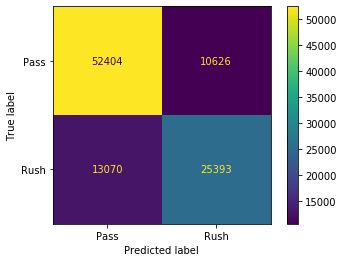

In [0]:
plot_confusion_matrix(xgb1, x_train_ft_imp_comp, y_train_ft_imp_comp, values_format='g' );

In [0]:

import pickle

In [0]:
# Saving the model to be able to use it later
fileName = 'xgb_classifier.pkl'
pickle.dump(xgb, open(fileName, 'wb'))

In [0]:
#xgb_model_loaded = pickle.load(open(file_name, "rb"))
theXgb = pickle.load(open(fileName, 'rb'))

In [0]:
theXgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, n_estimators=396, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Doing the import for the partial plot
from  pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
import shap

In [0]:
# Seeing what the features that I have in the x_train_feat_imp.columns
x_train_w_featImp.columns

Index(['Quarter', 'YardLine', 'Formation_NO HUDDLE SHOTGUN',
       'Formation_UNDER CENTER', 'Formation_SHOTGUN', 'Formation_NO HUDDLE',
       'IsTwoPointConversion', 'SecondsLeftInGame', 'Score',
       'yards_gained_prev_off_play', 'prev_offense_play_Pass',
       'prev_offense_play_Rush', 'prev_offense_play_No Previous',
       'prev_ply_bad_run', 'prev_ply_bad_pass', 'prev_ply_no_succ_run',
       'prev_ply_no_succ_pass', 'prev_ply_little_succ_run',
       'prev_ply_little_succ_pass', 'prev_ply_mild_succ_run',
       'prev_ply_succ_run', 'prev_ply_succ_pass', 'prev_ply_high_succ_run',
       'prev_ply_high_succ_pass', 'first_to_go', 'second_to_go', 'third_to_go',
       'fourth_to_go', 'two_point_to_go'],
      dtype='object')

In [0]:
# Making the interact object for the islating the Score
isolated = pdp_isolate(theXGB, 
                        x_train_w_featImp, x_train_w_featImp.columns,
                        feature='Score',
                        )

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2be0ed5e80>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bd36f50b8>})

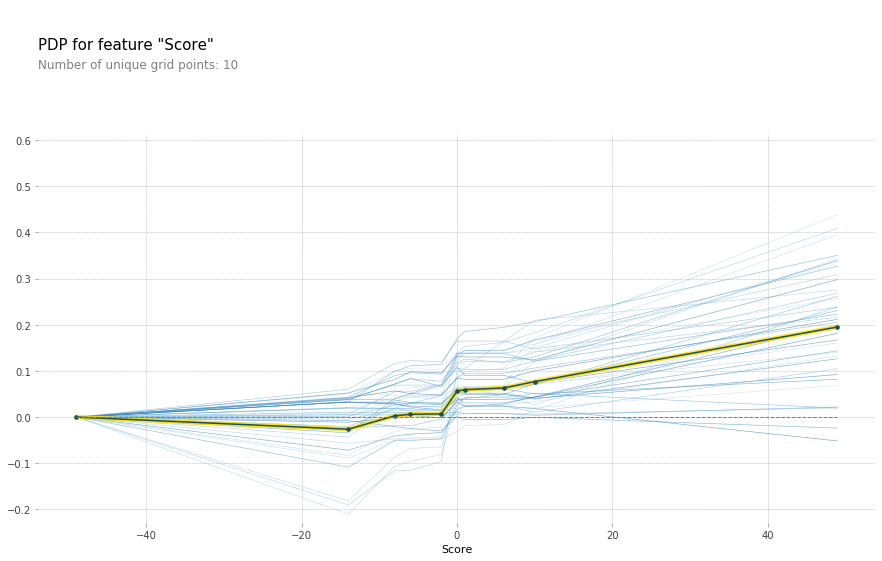

In [0]:
pdp_plot(isolated, feature_name='Score', plot_lines=True, frac_to_plot=40)


In [0]:
# making another isolate and then comparing as it changes
second_isolated = pdp_isolate(theXGB, x_train_w_featImp, x_train_w_featImp.columns, 
                              feature='YardLine' )

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bdf2ae8d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bdf437978>})

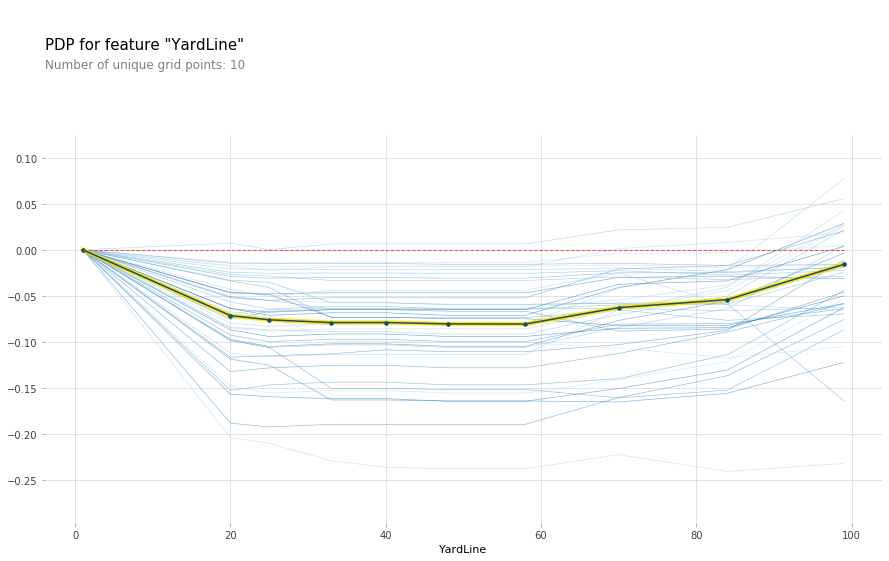

In [0]:
# Doing the second plot
pdp_plot(second_isolated, feature_name='YardLine', plot_lines=True,
         frac_to_plot=40)

In [0]:
# Doing the third plot of a partial plot
third_isolate = pdp_isolate(theXGB, x_train_w_featImp, x_train_w_featImp.columns, 
                            feature='SecondsLeftInGame')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bdf3ec940>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bdf26a978>})

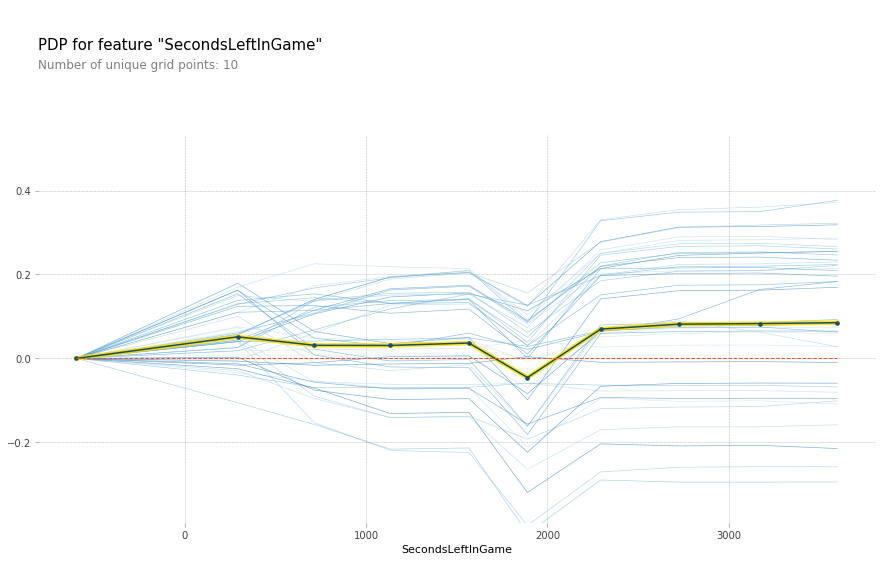

In [0]:
pdp_plot(third_isolate, feature_name='SecondsLeftInGame', plot_lines=True, 
         frac_to_plot=40)

In [0]:
theFeatures = ['Formation_NO HUDDLE SHOTGUN','Formation_UNDER CENTER', 
               'Formation_SHOTGUN', 'Formation_NO HUDDLE']

In [0]:
# Doing one last plot that is with several variables
fourth_isolate = pdp_isolate(theXGB, x_train_w_featImp, x_train_w_featImp.columns, feature=theFeatures)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bdf360390>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2bdf31a160>})

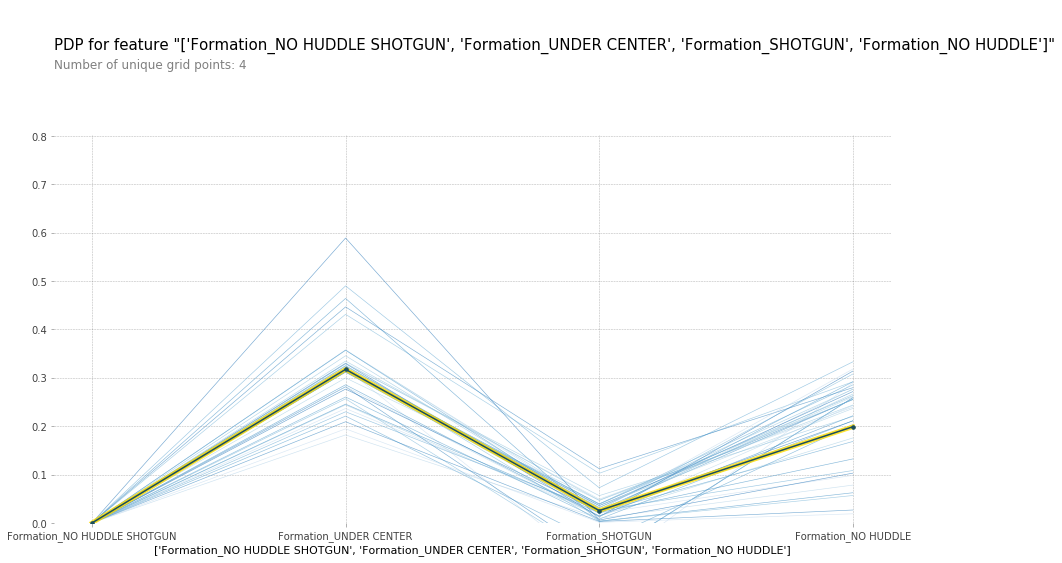

In [0]:
# Doing the plot:
pdp_plot(fourth_isolate, theFeatures, plot_lines=True, frac_to_plot=40)

In [0]:
# Doing a shapley type for one of the rows 
explainer = shap.TreeExplainer(theXGB)

In [0]:
# Picking our a row where the playType is a "Pass"
y_train.iloc[150] == "Rush"
# The values for the y are Rush or Pass

True

In [0]:
y_train.iloc[80] == 'Pass'

True

In [0]:
# Getting a Row that has a rush
rushRow = x_train_w_featImp.iloc[[150]] # With the double bracket it still is a dataFrame
passRow = x_train_w_featImp.iloc[[80]]
# Pulling out the y values for the rush and the run
y_rush = y_train.iloc[150]
y_pass = y_train.iloc[80]
                                 

In [0]:
rush_shap_vals = explainer.shap_values(rushRow, y=None )
pass_shap_vals = explainer.shap_values(passRow, y=None)

In [0]:
# Doing the force plot
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=rush_shap_vals, features=rushRow,
                )

In [0]:
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=pass_shap_vals, features=passRow, )

In [0]:
!pip install ipdb

In [0]:
import ipdb

[<matplotlib.lines.Line2D at 0x7f08b4d60358>]

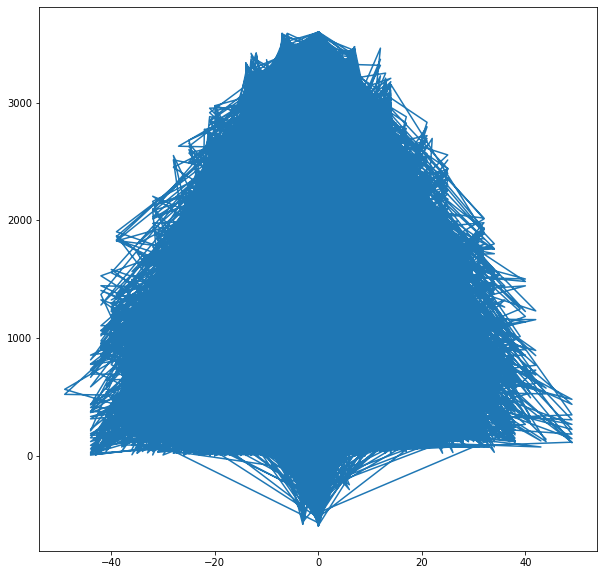

In [0]:
# This is a plot that is of the the score on the 
# x and on the y is the seconds left
# in the game.  It shows that the score diff at the start
# of the game is zero and then, if they make it to overtime,
# the score difference is again down to zero till someone wins the game.
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_train_w_featImp['Score'], x_train_w_featImp['SecondsLeftInGame'])
